In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler

import catboost as cb

from isic_helper import DotDict
from isic_helper import compute_auc, compute_pauc

import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "cb_v1"
# cfg.fold_column = "tsgkf_fold"
cfg.fold_column = "gkf_fold"

cfg.sampling_ratio = 0.01

In [3]:
id_column = "isic_id"
target_column = "target"
group_column = "patient_id"

ord_categorical_features = [
    "sex",
    "tbp_lv_location",
    "tbp_tile_type",
    "tbp_lv_location_simple",
]

ohe_categorical_features = [
    "anatom_site_general", 
    "attribution",
]

attribution_mapper = {
    "Memorial Sloan Kettering Cancer Center": "MSKCC",
    "ACEMID MIA": "ACEMIDMIA",
    "Department of Dermatology, Hospital Clínic de Barcelona": "DoD_HCB",
    "University Hospital of Basel": "UHB",
    "Frazer Institute, The University of Queensland, Dermatology Research Centre": "FI_TUQ-DRC",
    "Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris": "DoD_UA",
    "ViDIR Group, Department of Dermatology, Medical University of Vienna": "ViDIR"
}

def boosting_norm_feature(df, value_col, group_cols, err=1e-5):
    stats = ["mean", "std"]
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    feature_name = f"{value_col}_patient_norm"
    df[feature_name] = ((df[value_col] - df[f"{value_col}_mean"]) / 
                                       (df[f"{value_col}_std"] + err))
    return df, feature_name

def boosting_feature_engineering(df, err=1e-5):
    df["sex"] = df["sex"].fillna("missing_sex")
    df["anatom_site_general"] = df["anatom_site_general"].fillna("missing_anatom_site_general")
    df["tbp_tile_type"] = df["tbp_tile_type"].map({"3D: white": "white", "3D: XP": "XP"})
    df["attribution"] = df["attribution"].map(attribution_mapper)

    cols_to_norm = [
        "age_approx",
        "clin_size_long_diam_mm",
        "tbp_lv_A", "tbp_lv_Aext",
        "tbp_lv_B", "tbp_lv_Bext",
        "tbp_lv_C", "tbp_lv_Cext",
        "tbp_lv_H", "tbp_lv_Hext",
        "tbp_lv_L", "tbp_lv_Lext",
        "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio",
        "tbp_lv_color_std_mean",
        "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
        "tbp_lv_eccentricity",
        "tbp_lv_minorAxisMM", "tbp_lv_nevi_confidence", "tbp_lv_norm_border",
        "tbp_lv_norm_color", "tbp_lv_perimeterMM",
        "tbp_lv_radial_color_std_max", "tbp_lv_stdL", "tbp_lv_stdLExt",
        "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
        "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
    ]
    numerical_features = cols_to_norm[:]
    for col in cols_to_norm:
        df, feature_name = boosting_norm_feature(df, col, ["patient_id"])
        numerical_features += [feature_name]
    
    df["num_images"] = df["patient_id"].map(df.groupby("patient_id")["isic_id"].count())
    numerical_features += ["num_images"]
    return df, numerical_features


In [4]:
INPUT_PATH = Path("/kaggle/input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False, na_values=["NA"])
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv", low_memory=False, na_values=["NA"])

folds_df = pd.read_csv("/kaggle/input/isic-scd-folds/folds.csv")
train_metadata = train_metadata.merge(folds_df[[id_column, group_column, cfg.fold_column]], on=[id_column, group_column], how="left")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

train_metadata, numerical_features = boosting_feature_engineering(train_metadata)
test_metadata, _ = boosting_feature_engineering(test_metadata)

Train data size: (401059, 56)
Test data size: (3, 44)


In [5]:
cnn_model_names = ["efficientnet_b0", "efficientnet_b1"]
cnn_versions = ["v1", "v1"]
cnn_modes = ["trainmulti", "trainmulti"]
cnn_paths = [f"/kaggle/input/isic-scd-{model_name.replace('_', '-')}-{version}-{mode}" for model_name, version, mode in zip(cnn_model_names, cnn_versions, cnn_modes)]

all_cnn_oof_columns = []
for idx, path in enumerate(cnn_paths):
    model_name = cnn_model_names[idx]
    version = cnn_versions[idx]
    mode = cnn_modes[idx]
    cnn_oof_train_preds_model_df = pd.read_csv(f"{path}/oof_train_preds_{model_name}_{version}.csv")
    cnn_oof_columns = [col for col in cnn_oof_train_preds_model_df if col.startswith("oof_")]
    cnn_oof_new_columns = [f"{col}_{mode}" for col in cnn_oof_columns]
    columns_mapper = dict(zip(cnn_oof_columns, cnn_oof_new_columns))
    cnn_oof_train_preds_model_df = cnn_oof_train_preds_model_df.rename(columns=columns_mapper)
    all_cnn_oof_columns += cnn_oof_new_columns
    if idx == 0:
        cnn_oof_train_preds_df = cnn_oof_train_preds_model_df[[id_column] + cnn_oof_new_columns].copy()
    else:
        cnn_oof_train_preds_df = cnn_oof_train_preds_df.merge(cnn_oof_train_preds_model_df[[id_column] + cnn_oof_new_columns], on=id_column, how="left")
        assert cnn_oof_train_preds_df.shape[0] == cnn_oof_train_preds_model_df.shape[0]
train_metadata = train_metadata.merge(cnn_oof_train_preds_df, on=id_column, how="left")
numerical_features += all_cnn_oof_columns
cnn_oof_train_preds_df.head()

,isic_id,oof_efficientnet_b0_v1_trainmulti,oof_efficientnet_b0_v1_AKIEC_trainmulti,oof_efficientnet_b0_v1_BCC_trainmulti,oof_efficientnet_b0_v1_BKL_trainmulti,oof_efficientnet_b0_v1_DF_trainmulti,oof_efficientnet_b0_v1_MEL_trainmulti,oof_efficientnet_b0_v1_NV_trainmulti,oof_efficientnet_b0_v1_SCC_trainmulti,oof_efficientnet_b0_v1_VASC_trainmulti,oof_efficientnet_b0_v1_unknown_trainmulti,oof_efficientnet_b1_v1_trainmulti,oof_efficientnet_b1_v1_AKIEC_trainmulti,oof_efficientnet_b1_v1_BCC_trainmulti,oof_efficientnet_b1_v1_BKL_trainmulti,oof_efficientnet_b1_v1_DF_trainmulti,oof_efficientnet_b1_v1_MEL_trainmulti,oof_efficientnet_b1_v1_NV_trainmulti,oof_efficientnet_b1_v1_SCC_trainmulti,oof_efficientnet_b1_v1_VASC_trainmulti,oof_efficientnet_b1_v1_unknown_trainmulti
0,ISIC_0015845,0.004037,5.094003e-04,3.332987e-03,0.002011,6.720944e-04,0.000076,0.000500,6.279747e-04,3.136004e-06,0.992267,0.000443,0.000102,0.000284,0.000325,1.199100e-04,0.000065,0.000187,0.000094,4.595641e-06,0.998818
1,ISIC_0024200,0.000994,1.117348e-04,5.102379e-04,0.000457,9.707486e-05,0.000166,0.000391,3.172250e-04,2.089736e-06,0.997947,0.000337,0.000139,0.000157,0.000218,2.036671e-05,0.000066,0.000205,0.000115,3.252810e-06,0.999078
2,ISIC_0051648,0.000012,5.975414e-07,3.487163e-07,0.000006,2.460873e-08,0.000011,0.000033,5.772553e-07,3.375460e-11,0.999948,0.000104,0.000004,0.000005,0.000011,2.111230e-07,0.000096,0.000230,0.000003,1.907821e-08,0.999651
3,ISIC_0051896,0.000111,2.568727e-05,3.020867e-05,0.000029,3.024325e-06,0.000050,0.000047,3.082977e-05,1.567611e-08,0.999784,0.000024,0.000001,0.000003,0.000006,3.388210e-07,0.000020,0.000086,0.000001,2.455719e-08,0.999883
4,ISIC_0052026,0.000163,2.290148e-05,7.358967e-05,0.000090,3.277974e-05,0.000018,0.000101,7.104017e-05,2.160497e-07,0.999591,0.000097,0.000039,0.000031,0.000112,3.428573e-06,0.000018,0.000079,0.000048,4.579011e-07,0.999669


In [6]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown="ignore"),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [7]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata[cfg.fold_column]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

print(f"Total number of columns: {len(X_train.columns)}")
X_train.head()

Total number of columns: 106


,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,age_approx_patient_norm,clin_size_long_diam_mm_patient_norm,tbp_lv_A_patient_norm,tbp_lv_Aext_patient_norm,tbp_lv_B_patient_norm,tbp_lv_Bext_patient_norm,tbp_lv_C_patient_norm,tbp_lv_Cext_patient_norm,tbp_lv_H_patient_norm,tbp_lv_Hext_patient_norm,tbp_lv_L_patient_norm,tbp_lv_Lext_patient_norm,tbp_lv_areaMM2_patient_norm,tbp_lv_area_perim_ratio_patient_norm,tbp_lv_color_std_mean_patient_norm,tbp_lv_deltaA_patient_norm,tbp_lv_deltaB_patient_norm,tbp_lv_deltaL_patient_norm,tbp_lv_deltaLB_patient_norm,tbp_lv_deltaLBnorm_patient_norm,tbp_lv_eccentricity_patient_norm,tbp_lv_minorAxisMM_patient_norm,tbp_lv_nevi_confidence_patient_norm,tbp_lv_norm_border_patient_norm,tbp_lv_norm_color_patient_norm,tbp_lv_perimeterMM_patient_norm,tbp_lv_radial_color_std_max_patient_norm,tbp_lv_stdL_patient_norm,tbp_lv_stdLExt_patient_norm,tbp_lv_symm_2axis_patient_norm,tbp_lv_symm_2axis_angle_patient_norm,tbp_lv_x_patient_norm,tbp_lv_y_patient_norm,tbp_lv_z_patient_norm,num_images,oof_efficientnet_b0_v1_trainmulti,oof_efficientnet_b0_v1_AKIEC_trainmulti,oof_efficientnet_b0_v1_BCC_trainmulti,oof_efficientnet_b0_v1_BKL_trainmulti,oof_efficientnet_b0_v1_DF_trainmulti,oof_efficientnet_b0_v1_MEL_trainmulti,oof_efficientnet_b0_v1_NV_trainmulti,oof_efficientnet_b0_v1_SCC_trainmulti,oof_efficientnet_b0_v1_VASC_trainmulti,oof_efficientnet_b0_v1_unknown_trainmulti,oof_efficientnet_b1_v1_trainmulti,oof_efficientnet_b1_v1_AKIEC_trainmulti,oof_efficientnet_b1_v1_BCC_trainmulti,oof_efficientnet_b1_v1_BKL_trainmulti,oof_efficientnet_b1_v1_DF_trainmulti,oof_efficientnet_b1_v1_MEL_trainmulti,oof_efficientnet_b1_v1_NV_trainmulti,oof_efficientnet_b1_v1_SCC_trainmulti,oof_efficientnet_b1_v1_VASC_trainmulti,oof_efficientnet_b1_v1_unknown_trainmulti,sex,tbp_lv_location,tbp_tile_type,tbp_lv_location_simple,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_missing_anatom_site_general,anatom_site_general_posterior torso,anatom_site_general_upper extremity,attribution_ACEMIDMIA,attribution_DoD_HCB,attribution_DoD_UA,attribution_FI_TUQ-DRC,attribution_MSKCC,attribution_UHB,attribution_ViDIR
0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,0.000000,-0.463758,-0.105245,-0.259588,-0.133360,-1.058597,-0.166866,-0.998143,-0.007955,-0.502041,0.797304,0.550674,-0.676508,1.741324,-1.390228,0.221302,1.055810,0.505632,-0.397698,-0.527611,1.128511,-0.866238,-0.516717,2.172028,-1.408906,-0.394340,-1.340771,-0.254889,0.172754,2.161314,-0.002674,-0.718374,-1.187167,-0.891780,510,0.000493,0.000078,0.000233,0.000239,6.632954e-06,0.000038,0.000076,0.000222,1.583548e-06,0.999106,0.000048,0.000004,0.000021,0.000012,2.009249e-07,2.471096e-06,8.348658e-07,2.525086e-05,2.188352e-08,0.999935,1,12,1,4,0,0,1,0,0,0,0,0,0,0,1,0,0
1,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,0.000000,-1.843134,2.572084,2.520963,0.222639,0.508790,1.882886,2.021284,-1.484982,-1.705589,-1.136750,-1.406830,-1.137390,-1.4911

In [8]:
class PAUC:
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        y_true = target.astype(int)
        y_pred = approxes[0].astype(float)
        score = compute_pauc(y_true, y_pred, min_tpr=0.8)
        return score, 1.0


num_rounds = 3000
es_rounds = 250
log_rounds = 50

params = {
    "objective":         "Logloss",
    "random_state":      cfg.seed,
    "max_depth":         7, 
    "learning_rate":     0.01, 
    "scale_pos_weight":  2.6149345838209532, 
    "l2_leaf_reg":       6.216113851699493, 
    "subsample":         0.6249261779711819, 
    "min_data_in_leaf":  24,
    "cat_features":      categorical_features,
}

In [9]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.unique(folds)
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    rus = RandomUnderSampler(sampling_strategy=cfg.sampling_ratio, random_state=cfg.seed)
    X_dev, y_dev = rus.fit_resample(X_dev, y_dev) 
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    cb_dataset_dev = cb.Pool(X_dev, y_dev, cat_features=categorical_features)
    cb_dataset_val = cb.Pool(X_val, y_val, cat_features=categorical_features)
    
    model = cb.CatBoostClassifier(**params, iterations=num_rounds, eval_metric=PAUC())
    model.fit(cb_dataset_dev, 
              eval_set=cb_dataset_val, 
              early_stopping_rounds=es_rounds, 
              metric_period=log_rounds, 
              use_best_model=True)
    best_num_rounds[f"fold_{fold}"] = model.best_iteration_
    
    val_preds = model.predict_proba(X_val)[:, -1]
    oof_predictions[val_index] = val_preds
    
    val_auc_scores[f"fold_{fold}"] = compute_auc(y_val, val_preds)
    val_pauc_scores[f"fold_{fold}"] = compute_pauc(y_val, val_preds, min_tpr=0.8)
    print("\n")
    
    with open(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt", "wb") as f:
        joblib.dump(model, f)

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_train_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_train_preds_df.to_csv(f"oof_train_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_train_preds_df[target_column], oof_train_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_train_preds_df[target_column], oof_train_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(f"CV PAUC RANGE: ({cv_pauc_avg - cv_pauc_std}, {cv_pauc_avg + cv_pauc_std})")
print(X_train.columns)

Running fold: 1


/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_19/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1273860	test: 0.1156155	best: 0.1156155 (0)	total: 1.31s	remaining: 1h 5m 38s
50:	learn: 0.1790011	test: 0.1861407	best: 0.1861407 (50)	total: 5.93s	remaining: 5m 42s
100:	learn: 0.1797170	test: 0.1879092	best: 0.1879092 (100)	total: 10.9s	remaining: 5m 14s
150:	learn: 0.1815514	test: 0.1883773	best: 0.1883773 (150)	total: 15.5s	remaining: 4m 51s
200:	learn: 0.1832605	test: 0.1888275	best: 0.1888791 (198)	total: 19.9s	remaining: 4m 37s
250:	learn: 0.1848100	test: 0.1891975	best: 0.1891975 (250)	total: 24.4s	remaining: 4m 27s
300:	learn: 0.1862969	test: 0.1894924	best: 0.1895136 (297)	total: 28.9s	remaining: 4m 19s
350:	learn: 0.1876216	test: 0.1897897	best: 0.1897897 (350)	total: 33.4s	remaining: 4m 12s
400:	learn: 0.1886914	test: 0.1900241	best: 0.1900310 (398)	total: 38s	remaining: 4m 6s
450:	learn: 0.1895505	test: 0.1902415	best: 0.1902415 (450)	total: 43s	remaining: 4m 3s
500:	learn: 0.1906083	test: 0.1903475	best: 0.1903475 (500)	total: 47.5s	remaining: 3m 57s
550:	lea

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_19/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1261374	test: 0.1308889	best: 0.1308889 (0)	total: 204ms	remaining: 10m 13s
50:	learn: 0.1825076	test: 0.1782082	best: 0.1782082 (50)	total: 4.81s	remaining: 4m 38s
100:	learn: 0.1827582	test: 0.1798254	best: 0.1799866 (96)	total: 9.35s	remaining: 4m 28s
150:	learn: 0.1843230	test: 0.1808702	best: 0.1808702 (150)	total: 14s	remaining: 4m 23s
200:	learn: 0.1857804	test: 0.1817528	best: 0.1817661 (198)	total: 18.5s	remaining: 4m 17s
250:	learn: 0.1873700	test: 0.1819864	best: 0.1820010 (246)	total: 23.1s	remaining: 4m 13s
300:	learn: 0.1886056	test: 0.1820832	best: 0.1821096 (292)	total: 27.7s	remaining: 4m 8s
350:	learn: 0.1899333	test: 0.1822690	best: 0.1822796 (349)	total: 32.8s	remaining: 4m 7s
400:	learn: 0.1910949	test: 0.1823440	best: 0.1823511 (399)	total: 37.4s	remaining: 4m 2s
450:	learn: 0.1922189	test: 0.1823873	best: 0.1824625 (414)	total: 42s	remaining: 3m 57s
500:	learn: 0.1930449	test: 0.1823586	best: 0.1824625 (414)	total: 46.6s	remaining: 3m 52s
550:	learn: 

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_19/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1424329	test: 0.1125995	best: 0.1125995 (0)	total: 235ms	remaining: 11m 45s
50:	learn: 0.1853977	test: 0.1605388	best: 0.1611864 (43)	total: 5.22s	remaining: 5m 2s
100:	learn: 0.1854626	test: 0.1602058	best: 0.1611864 (43)	total: 9.84s	remaining: 4m 42s
150:	learn: 0.1872652	test: 0.1611871	best: 0.1612809 (143)	total: 14.5s	remaining: 4m 33s
200:	learn: 0.1887158	test: 0.1624569	best: 0.1624778 (199)	total: 19.1s	remaining: 4m 26s
250:	learn: 0.1897445	test: 0.1631577	best: 0.1631577 (250)	total: 23.7s	remaining: 4m 19s
300:	learn: 0.1908063	test: 0.1636832	best: 0.1636832 (300)	total: 28.2s	remaining: 4m 13s
350:	learn: 0.1917964	test: 0.1643754	best: 0.1643975 (349)	total: 33s	remaining: 4m 8s
400:	learn: 0.1928021	test: 0.1648207	best: 0.1649037 (389)	total: 37.8s	remaining: 4m 5s
450:	learn: 0.1936050	test: 0.1652636	best: 0.1652745 (446)	total: 42.4s	remaining: 3m 59s
500:	learn: 0.1943420	test: 0.1655765	best: 0.1655765 (500)	total: 47s	remaining: 3m 54s
550:	learn: 

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_19/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1173567	test: 0.1113749	best: 0.1113749 (0)	total: 176ms	remaining: 8m 46s
50:	learn: 0.1816475	test: 0.1782793	best: 0.1782793 (50)	total: 4.8s	remaining: 4m 37s
100:	learn: 0.1823464	test: 0.1803514	best: 0.1806203 (87)	total: 9.77s	remaining: 4m 40s
150:	learn: 0.1846002	test: 0.1805865	best: 0.1807610 (138)	total: 14.3s	remaining: 4m 29s
200:	learn: 0.1864619	test: 0.1806966	best: 0.1807610 (138)	total: 18.8s	remaining: 4m 22s
250:	learn: 0.1878449	test: 0.1809251	best: 0.1810311 (239)	total: 23.4s	remaining: 4m 15s
300:	learn: 0.1892113	test: 0.1813045	best: 0.1813137 (298)	total: 27.9s	remaining: 4m 10s
350:	learn: 0.1903531	test: 0.1815951	best: 0.1816109 (347)	total: 32.5s	remaining: 4m 5s
400:	learn: 0.1912665	test: 0.1817731	best: 0.1817755 (399)	total: 37s	remaining: 3m 59s
450:	learn: 0.1921993	test: 0.1817848	best: 0.1819021 (427)	total: 42.1s	remaining: 3m 57s
500:	learn: 0.1931698	test: 0.1815277	best: 0.1819021 (427)	total: 46.6s	remaining: 3m 52s
550:	learn

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_19/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1273494	test: 0.0825665	best: 0.0825665 (0)	total: 205ms	remaining: 10m 14s
50:	learn: 0.1821430	test: 0.1759444	best: 0.1759709 (46)	total: 4.8s	remaining: 4m 37s
100:	learn: 0.1825297	test: 0.1763556	best: 0.1764169 (76)	total: 9.73s	remaining: 4m 39s
150:	learn: 0.1838555	test: 0.1768924	best: 0.1769297 (149)	total: 14.2s	remaining: 4m 28s
200:	learn: 0.1851288	test: 0.1777706	best: 0.1778374 (198)	total: 18.7s	remaining: 4m 20s
250:	learn: 0.1863464	test: 0.1780278	best: 0.1780667 (248)	total: 23.2s	remaining: 4m 14s
300:	learn: 0.1874881	test: 0.1784384	best: 0.1784989 (296)	total: 27.7s	remaining: 4m 8s
350:	learn: 0.1887382	test: 0.1792631	best: 0.1792631 (350)	total: 32.3s	remaining: 4m 3s
400:	learn: 0.1896224	test: 0.1793480	best: 0.1793721 (397)	total: 36.9s	remaining: 3m 59s
450:	learn: 0.1904949	test: 0.1793290	best: 0.1794256 (439)	total: 42s	remaining: 3m 57s
500:	learn: 0.1914531	test: 0.1793891	best: 0.1795689 (484)	total: 46.5s	remaining: 3m 52s
550:	learn

In [10]:
feature_importances = 0
for fold in all_folds:
    model_filepath = MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt"
    with open(model_filepath, "rb") as f:
        model = joblib.load(f)
    if fold == 1:
        feature_names = model.feature_names_
    feature_importances += model.feature_importances_
feature_importances = feature_importances.astype(np.float32)
feature_importances /= len(all_folds)

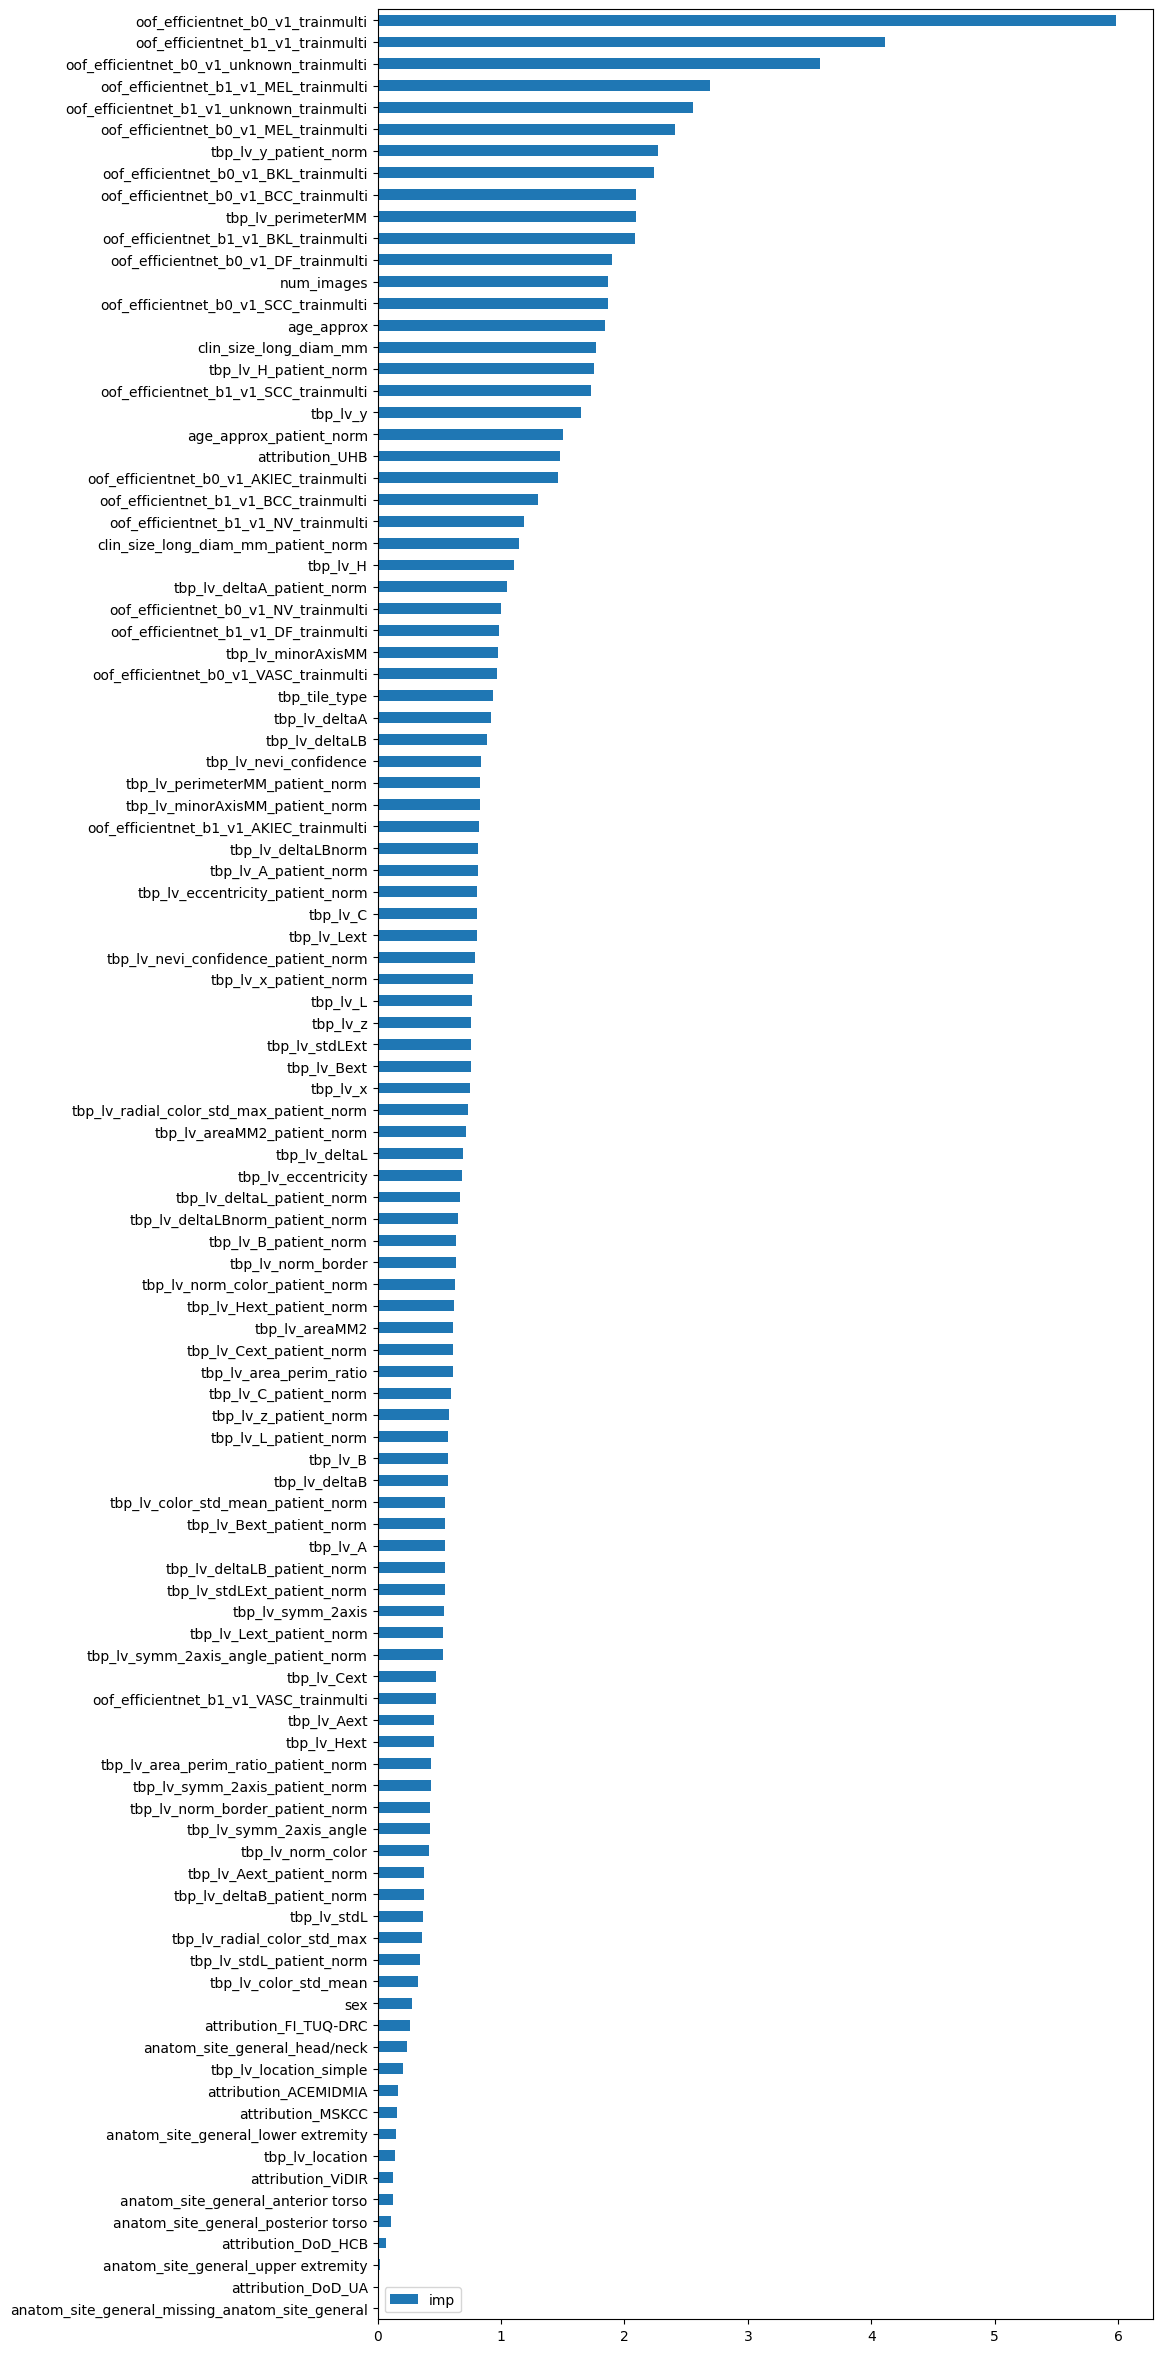

In [11]:
imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 30))
plt.show() 

In [12]:
metadata = {
    "config": cfg.__dict__,
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg,
    "cv_auc_std": cv_auc_std,
    "cv_pauc_std": cv_pauc_std
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)


In [13]:
metadata

{'config': {'_temp': False,
  '_key': None,
  '_parent': None,
  'seed': 2022,
  'models_output_dir': 'models',
  'model_name': 'cb_v1',
  'fold_column': 'gkf_fold',
  'sampling_ratio': 0.01},
 'params': {'objective': 'Logloss',
  'random_state': 2022,
  'max_depth': 7,
  'learning_rate': 0.01,
  'scale_pos_weight': 2.6149345838209532,
  'l2_leaf_reg': 6.216113851699493,
  'subsample': 0.6249261779711819,
  'min_data_in_leaf': 24,
  'cat_features': ['sex',
   'tbp_lv_location',
   'tbp_tile_type',
   'tbp_lv_location_simple',
   'anatom_site_general_anterior torso',
   'anatom_site_general_head/neck',
   'anatom_site_general_lower extremity',
   'anatom_site_general_missing_anatom_site_general',
   'anatom_site_general_posterior torso',
   'anatom_site_general_upper extremity',
   'attribution_ACEMIDMIA',
   'attribution_DoD_HCB',
   'attribution_DoD_UA',
   'attribution_FI_TUQ-DRC',
   'attribution_MSKCC',
   'attribution_UHB',
   'attribution_ViDIR']},
 'num_rounds': 3000,
 'es_round